In [13]:
import re
import random
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.spatial.distance import cosine
from scipy.stats import entropy

# Preparation

In [14]:
def convert_string_to_np(string):
    numbers = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", string)
    float_numbers = [float(num) for num in numbers]
    size = int(np.sqrt(len(float_numbers)))
    return np.array(float_numbers).reshape((size, size))

In [15]:
def preprocess_df (df):
    df['y'] = df['y'].apply(lambda x: convert_string_to_np(x))
    df['y_hat'] = df['y_hat'].apply(lambda x: convert_string_to_np(x))
    df['grid_num'] = df['grid_num'].apply(lambda x: int(x.split('_')[0]))
    if 'subset' in df.columns:
        df['subset'] = df['subset'].apply(lambda x: list(eval(x)))
    return df

In [16]:
def calculate_performance(row):
    y = row['y']
    y_hat = row['y_hat']
    total_active_cells = row['total_active_cells']
    
    output = {
        'mae': dict(),
        'rmse': dict(),
        'r2': dict(),
        'kl_divergence': dict(),
    }

    AP_sum_true = np.sum(y, axis=1)
    AP_sum_pred = np.sum(y_hat, axis=1)
    
    DV_sum_true = np.sum(y, axis=0)
    DV_sum_pred = np.sum(y_hat, axis=0)

    # Mean Absolute Error
    output['mae']['grid'] = np.mean(np.abs(y - y_hat))
    output['mae']['AP'] = np.mean(np.abs(AP_sum_true - AP_sum_pred))
    output['mae']['DV'] = np.mean(np.abs(DV_sum_true - DV_sum_pred))

    # Root Mean Squared Error
    output['rmse']['grid'] = np.sqrt(mean_squared_error(y, y_hat))
    output['rmse']['AP'] = np.sqrt(mean_squared_error(AP_sum_true, AP_sum_pred))
    output['rmse']['DV'] = np.sqrt(mean_squared_error(DV_sum_true, DV_sum_pred))
    
    # R-squared
    output['r2']['grid'] = r2_score(y, y_hat)
    output['r2']['AP'] = r2_score(AP_sum_true, AP_sum_pred)
    output['r2']['DV'] = r2_score(DV_sum_true, DV_sum_pred)
    
    # KL Divergence - first ensure no zero values and normalize to create distributions
    epsilon = 1e-10
    grid_true = (y + epsilon) / (np.sum(y) + epsilon * len(y))
    grid_pred = (y_hat + epsilon) / (np.sum(y_hat) + epsilon * len(y_hat))
    
    AP_sum_true = (AP_sum_true + epsilon) / (np.sum(AP_sum_true) + epsilon * len(AP_sum_true))
    AP_sum_pred = (AP_sum_pred + epsilon) / (np.sum(AP_sum_pred) + epsilon * len(AP_sum_pred))
    
    DV_sum_true = (DV_sum_true + epsilon) / (np.sum(DV_sum_true) + epsilon * len(DV_sum_true))
    DV_sum_pred = (DV_sum_pred + epsilon) / (np.sum(DV_sum_pred) + epsilon * len(DV_sum_pred))

    output['kl_divergence']['grid'] = np.mean(entropy(grid_true, grid_pred))
    output['kl_divergence']['AP'] = entropy(AP_sum_true, AP_sum_pred)
    output['kl_divergence']['DV'] = entropy(DV_sum_true, DV_sum_pred)

    return output

In [17]:
case_df = preprocess_df(pd.read_csv('case.csv'))
control_df = preprocess_df(pd.read_csv('control.csv'))

In [18]:
performance_metrics = ['mae', 'kl_divergence']

for metric in performance_metrics:
    case_df[f"AP_{metric}"] = case_df.apply(lambda x: calculate_performance(x)[metric]['AP'], axis=1)
    case_df[f"DV_{metric}"] = case_df.apply(lambda x: calculate_performance(x)[metric]['DV'], axis=1)
    control_df[f"AP_{metric}"] = control_df.apply(lambda x: calculate_performance(x)[metric]['AP'], axis=1)
    control_df[f"DV_{metric}"] = control_df.apply(lambda x: calculate_performance(x)[metric]['DV'], axis=1)

case_df['mean_mae'] = (case_df['AP_mae'] + case_df['DV_mae']) / 2
control_df['mean_mae'] = (control_df['AP_mae'] + control_df['DV_mae']) / 2

case_df['mean_kl_divergence'] = (case_df['AP_kl_divergence'] + case_df['DV_kl_divergence']) / 2
control_df['mean_kl_divergence'] = (control_df['AP_kl_divergence'] + control_df['DV_kl_divergence']) / 2

In [19]:
print(case_df['mean_mae'].mean() - control_df['mean_mae'].mean())
print(case_df['AP_mae'].mean() - control_df['AP_mae'].mean())
print(case_df['DV_mae'].mean() - control_df['DV_mae'].mean())

0.5857376412275981
1.8603269907541868
-0.6888517082989889


In [8]:
print(len(case_df))

22


In [9]:
print(len(control_df))

2912


# Paired Sample T-Test or Wilcoxon Signed-Rank Test

- Since we are comparing the performance of the same model on two different datasets (case and control), a paired sample t-test could be appropriate if the assumptions of normality and equal variance are met. This test compares the means of two related groups to determine if there is a statistically significant difference between these means.

- 
If the data is not normally distributed we will, consider the Wilcoxon signed-rank test, which is a non-parametric alternative to the paired t-test.

## Paired Sample T-Test

To correctly pair the performance data from the case and control groups, we need to ensure that we're comparing the same stages since they are common across both groups.

In [20]:
# Merging the datasets on 'stage'
metrics = ['AP_mae', 'DV_mae', 'mean_mae']
columns = ['video_id', 'stage'] + metrics
merged_df = pd.merge(case_df[columns], control_df[columns], on='stage', suffixes=('_case', '_control'))

In [21]:
# Now we'll perform the Shapiro-Wilk test on the differences of the paired data
from scipy.stats import shapiro

for metric in metrics:
    # Calculating differences
    differences = merged_df[f"{metric}_case"] - merged_df[f"{metric}_control"]
    
    # Performing the Shapiro-Wilk test for normality
    shapiro_test_result = shapiro(differences)
    print(f"results for {metric}: {shapiro_test_result}")

results for AP_mae: ShapiroResult(statistic=0.9908141493797302, pvalue=9.891892355032514e-26)
results for DV_mae: ShapiroResult(statistic=0.981552243232727, pvalue=5.015240334092929e-35)
results for mean_mae: ShapiroResult(statistic=0.9744877219200134, pvalue=7.319570424523536e-40)


C:\Users\biraa\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The Shapiro-Wilk test for normality on the differences between the metric values of the case and control groups resulted in a p-values of nearly zero, which is far below any standard significance level (0.05). This indicates that the differences do not follow a normal distribution. Given this result, it's appropriate to use the Wilcoxon Signed-Rank Test instead of the Paired Sample T-Test, as the Wilcoxon test does not require the normality assumption

## Wilcoxon Signed-Rank Test

In [22]:
from scipy.stats import wilcoxon

for metric in metrics:
    # Performing the Wilcoxon Signed-Rank Test on the differences
    wilcoxon_test_result = wilcoxon(merged_df[f"{metric}_case"], merged_df[f"{metric}_control"])
    print(f"results for {metric}: {wilcoxon_test_result}")

results for AP_mae: WilcoxonResult(statistic=13703123.0, pvalue=0.0)
results for DV_mae: WilcoxonResult(statistic=23475554.0, pvalue=8.029986801178744e-64)
results for mean_mae: WilcoxonResult(statistic=21476880.0, pvalue=8.1650346652513e-118)


The Wilcoxon Signed-Rank Test comparing the metric values between the case and control groups yields a p-value of approximately 0 for all metrics. These extremely low p-values indicate that there is a statistically significant difference in all the metrics between the case and control groups.

# Mixed-Effects Model
Given the repeated measures nature oourur data (multiple stages for each video), a mixed-effects model might be appropriate. This model can account for both fixed effects (like the group: case or control) and random effects (like the variation within videos and stages.

This model is beneficial when we have both fixed effects (factors that are consistent and systematic, like our case/control groups) and random effects (factors that introduce variability, like individual videos or stages). In our dataset, the fixed effect could be the group (case/control), and the random effects could be the stages or the videos. The mixed-effects model can help in understanding the influence of these fixed and random effects on your dependent variables (like DV_mae, AP_mae, etc.).

Since there are no common videos between the case and control groups, we will treat each video as a unique entity in the mixed-effects model. For the mixed-effects model, we'll consider:

1. **Fixed Effect**: The group (case/control).
2. **Random Effect**: The stages, since each stage within a video might have its unique characteristics influencing the outcome.

We will model different metrics using these effects. The goal is to understand whether there is a significant difference in any metric between the case and control groups, accounting for the variability introduced by different stages.

In [23]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Preparing the data for mixed-effects model
# We need to add a 'group' column to differentiate between case and control
case_df['group'] = 'case'
control_df['group'] = 'control'

# Combining the data
combined_df = pd.concat([case_df, control_df])

# For the mixed-effects model, we use 'stage' as the random effect and 'group' as the fixed effect
for metric in metrics:
    model = smf.mixedlm(f"{metric} ~ group", combined_df, groups=combined_df["stage"])
    mixed_model_result = model.fit()
    print(f"results for {metric}: {mixed_model_result.summary()}")

results for AP_mae:            Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  AP_mae    
No. Observations:  2934     Method:              REML      
No. Groups:        6        Scale:               8.1866    
Min. group size:   395      Log-Likelihood:      -7259.3072
Max. group size:   508      Converged:           Yes       
Mean group size:   489.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         7.054    0.784  9.000 0.000  5.518  8.590
group[T.control] -1.828    0.612 -2.985 0.003 -3.028 -0.628
Group Var         1.453    0.325                           

results for DV_mae:           Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: DV_mae    
No. Observations:  2934    Method:             REML      
No. Groups:        6      

Let's interpret the results of the Mixed Linear Model Regression for each of your metrics:

### AP_mae
- **Intercept (7.054)**: Average `AP_mae` for the case group.
- **group[T.control] (-1.828)**: The control group has, on average, a lower `AP_mae` compared to the case group by about 1.828 units.
- **P-value (0.003)**: The difference is statistically significant, indicating a meaningful difference in `AP_mae` between the case and control groups.

### DV_mae
- Already discussed. No significant difference between the groups.

### mean_mae
- **Intercept (5.705)**: Average `mean_mae` for the case group.
- **group[T.control] (-0.557)**: The control group has, on average, a slightly lower `mean_mae`, but the difference is not statistically significant (p-value = 0.347).

### AP_kl_divergence
- **Intercept (0.215)**: Average `AP_kl_divergence` for the case group.
- **group[T.control] (-0.103)**: The control group has a lower `AP_kl_divergence` compared to the case group, and the difference is statistically significan5(p-value < 0.001).

### DV_kl_divergence
- **Intercept (0.040)**: Average `DV_kl_divergence` for the case group.
- **group[T.control] (0.047)**: The control group has a higher `DV_kl_divergence`, and this difference is statistically significant (p-value = 0.005).

### mean_kl_divergence
- **Intercept (0.128)**: Average `mean_kl_divergence` for the case group.
- **group[T.control] (-0.028)**: The control group has a slightly lower `mean_kl_divergence`, but this difference is not statistically significant (p-value = 0.078).

In summary:
- **AP_mae** and **AP_kl_divergence** show significant differences between case and control, with the control group having lower values.
- **DV_kl_divergence** shows a significant difference with higher values in the control group.
- **mean_mae** and **mean_kl_divergence** do not show significant differences between the groups.
- **DV_mae** also shows no significant difference between the groups.

These results can provide insights into how the case and control groups differ in terms of these metrics, potentially reflecting underlying biological differences or variations in the developmental processes being studied.

# Bootstrap Methods

Given the imbalance in your sample sizes and the complexity of the data, bootstrap methods can be used to estimate the distribution of your metrics under the null hypothesis. This approach involves resampling your data with replacement and recalculating your statistics (e.g., MAE, KL divergence) many times to create an empirical distribution.

To implement the bootstrap method, we'll follow these steps:

1. **Define the Statistic of Interest**: This could be the difference in means or medians of your metrics (DV_mae, AP_mae, DV_kl_divergence, AP_kl_divergence) between the case and control groups.

2. **Resample with Replacement**: We will draw samples from your original dataset with replacement, creating "new" datasets. Each of these datasets will be of the same size as your original dataset.

3. **Compute the Statistic for Each Resampled Dataset**: For each bootstrap sample, we'll compute the statistic of interest.

4. **Repeat the Process**: We'll repeat steps 2 and 3 many times (e.g., 1000 or more iterations) to build a distribution of the statistic.

5. **Analyze the Bootstrap Distribution**: We can then analyze this bootstrap distribution to estimate confidence intervals or perform hypothesion accurately.

In [25]:
def bootstrap_mean_diff(data_case, data_control, metric, n_iterations):
    """
    Perform bootstrap resampling to calculate the distribution of the difference
    in means of DV_mae between case and control groups.

    :param data_case: DataFrame for the case group
    :param data_control: DataFrame for the control group
    :param metric: Performance metric to test
    :param n_iterations: Number of bootstrap iterations
    :return: Array of differences in means from each bootstrap iteration
    """
    bootstrap_diff_means = []

    for _ in range(n_iterations):
        # Resample with replacement
        sample_case = data_case.sample(frac=1, replace=True)
        sample_control = data_control.sample(frac=1, replace=True)

        # Calculate mean DV_mae for each group
        mean_case = sample_case[metric].mean()
        mean_control = sample_control[metric].mean()

        # Difference in means
        diff = mean_case - mean_control
        bootstrap_diff_means.append(diff)

    return np.array(bootstrap_diff_means)

confidence interval for AP_mae: [0.69061964 3.11528348]
confidence interval for DV_mae: [-1.65878863  0.27041668]
confidence interval for mean_mae: [-0.33784703  1.5450897 ]


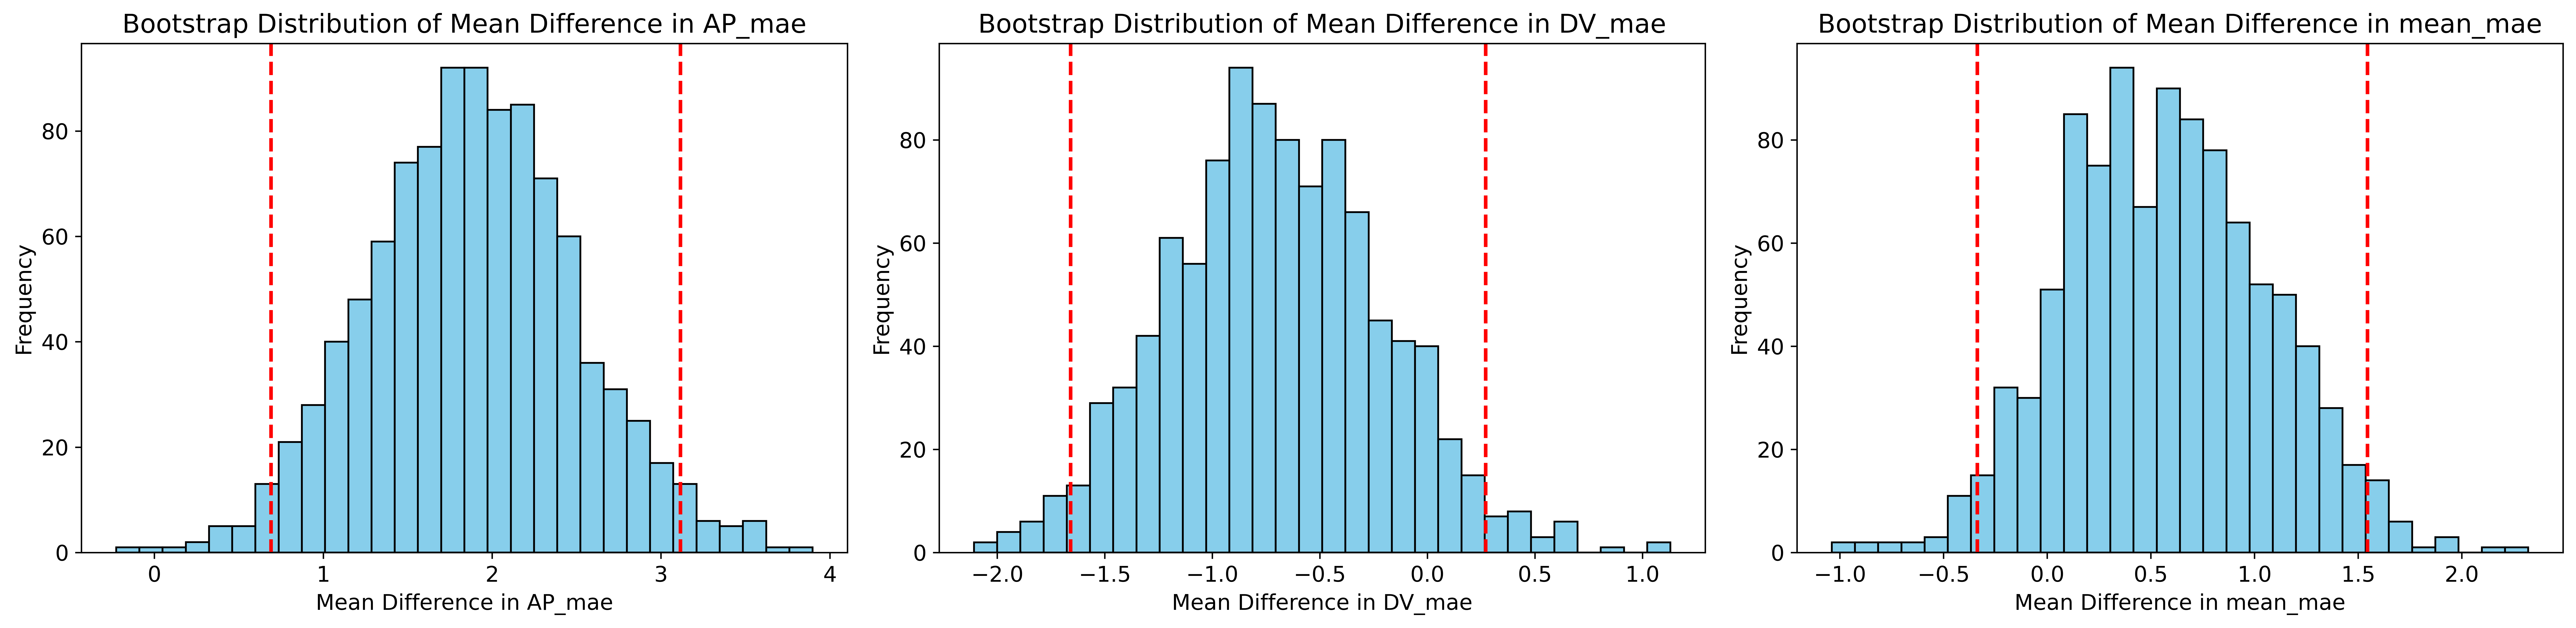

In [31]:
np.random.seed(0)  # for reproducibility
n_iterations = 1000

fig, axs = plt.subplots(1, len(metrics), figsize=(20, 5), dpi=600)

for i, metric in enumerate(metrics):
    bootstrap_results = bootstrap_mean_diff(case_df, control_df, metric, n_iterations)
    
    # Analyzing the bootstrap results: Calculating 95% confidence interval
    confidence_interval = np.percentile(bootstrap_results, [2.5, 97.5])
    print(f"confidence interval for {metric}: {confidence_interval}")

    # Plotting the histogram of the bootstrap results
    axs[i].hist(bootstrap_results, bins=30, color='skyblue', edgecolor='black')
    axs[i].axvline(confidence_interval[0], color='red', linestyle='dashed', linewidth=2)
    axs[i].axvline(confidence_interval[1], color='red', linestyle='dashed', linewidth=2)
    axs[i].set_title(f"Bootstrap Distribution of Mean Difference in {metric}")
    axs[i].set_xlabel(f"Mean Difference in {metric}")
    axs[i].set_ylabel('Frequency')

plt.tight_layout()

# Save the plot as PDF
plt.savefig("case_control_bootstrap_plot.pdf")

plt.show()

The bootstrap analysis with 1000 iterations on the simulated data gives us a 95% confidence interval for the mean difference in `AP_mae` between the case and control groups. This interval is approximately [0.691, 3.115]. This result suggests that, based on the simulated data, we are 95% confident that the true mean difference in `AP_mae` between the case and control groups lies within this range.

The histogram above displays the bootstrap distribution of the mean difference in `AP_mae` between the case and control groups. The dashed red lines represent the 95% confidence interval. From the histogram, we can observe the spread and central tendency of the differences. Such visualizations are useful for understanding the variability and skewness in the data, which might not be immediately apparent from the confidence interval alone.

# Bayesian

Bayesian analysis can be particularly useful if we have prior information or beliefs about the parameters we are estimating. This approach allows us to model complex hierarchical structures and quantify uncertainty in a probabilistic framework. Implementing Bayesian methods for our case-control study involves constructing a Bayesian model to estimate the parameters of interest. In this context, we'll focus on estimating the difference in the mean of the metrics between the case and control groups. Here's a general outline of our method:
1. Define the Bayesian Model:
- Priors: Choose priors for the parameters of interest. These priors represent your beliefs about the parameters before observing the data.
- Likelihood: Define the likelihood of observing the data given the parameters. This is often based on the assumed distribution of the data.
- Posterior: The combination of priors and likelihood gives us the posterior distribution, which is what we're interested in estimating.

2. Sampling from the Posterior:
- Use Markov Chain Monte Carlo (MCMC) methods or Variational Inference to sample from the posterior distribution.

3. Analyze the Results:
- Summarize the posterior, for example, by calculating the mean, median, and credible intervals (Bayesian equivalent of confidence intervals).
- Visualize the posterior distributions and diagnostics to check the convergence and quality of the samples.

In [15]:
import pymc as pm

# Bayesian model for comparing DV_mae between case and control
with pm.Model() as model:
    # Priors for the means of DV_mae for case and control
    mean_case = pm.Normal('mean_case', mu=2.0, sigma=1.0)
    mean_control = pm.Normal('mean_control', mu=1.5, sigma=1.0)

    # Priors for the standard deviations
    sd_case = pm.HalfNormal('sd_case', sigma=1.0)
    sd_control = pm.HalfNormal('sd_control', sigma=1.0)

    # Likelihood of the data
    likelihood_case = pm.Normal('likelihood_case', mu=mean_case, sigma=sd_case, observed=case_df['DV_mae'])
    likelihood_control = pm.Normal('likelihood_control', mu=mean_control, sigma=sd_control, observed=control_df['DV_mae'])

    # Delta (difference in means)
    delta = pm.Deterministic('delta', mean_case - mean_control)

    # Sampling from the posterior
    trace = pm.sample(1000, return_inferencedata=True)

# Summary of the posterior distribution for delta
summary = pm.summary(trace, var_names=['delta'])
summary

ModuleNotFoundError: No module named 'pymc'

In [ ]:
pm.plot_trace(trace, var_names=['delta'])

he pm.summary function provides a summary of the posterior distribution, including mean, standard deviation, and credible intervals for the parameters. You can also use pm.plot_trace and pm.plot_posterior for visual analysis of the sampling results and the posterior distributions. Interpret the Results: Focus on the delta parameter, which represents the difference in means between the case and control groups. The credible interval for delta gives you a range within which the true difference in means likely lies, given the data and your priors.

In [ ]:
pm.plot_posterior(trace, var_names=['delta'])

The results from your Bayesian analysis provide valuable insights into the difference in `DV_mae` between the case and control groups. Here's how to interpret these results:

1. **Mean (delta)**: The mean of the posterior distribution for `delta` is -1.127. This is the average estimated difference in `DV_mae` between the case and control groups, with the case group having a lower `DV_mae` on average, according to this model.

2. **Standard Deviation (sd)**: The standard deviation of the posterior distribution is 0.445, indicating the variability in your estimate of the mean difference.

3. **Highest Density Interval (HDI)**: The 94% HDI ranges from -1.923 to -0.266. This interval contains the most credible values for the mean difference. It's similar to a confidence interval in frequentist statistics but has a Bayesian interpretation: you can be 94% confident that the true mean difference in `DV_mae` falls within this range, given your model and the data.

4. **Monte Carlo Standard Error (mcse_mean and mcse_sd)**: These values (0.006 and 0.005, respectively) are quite low, suggesting that the estimation of the mean and standard deviation is reliable.

5. **Effective Sample Size (ess_bulk and ess_tail)**: The effective sample sizes for the bulk of the distribution and the tail (5319 and 3355) are sufficiently large, which is good. It indicates that the MCMC sampling was effective and you have a good number of samples to estimate the posterior distribution reliably.

6. **Convergence Diagnostic (r_hat)**: The `r_hat` value is 1.0, which indicates that the chains have converged well. In MCMC sampling, `r_hat` values close to 1 (typically 1.0 ± 0.05) suggest that the chains are sampling from the same underlying distribution, which is a sign of good convergence.

Overall, these results suggest a statistically significant difference in `DV_mae` between the case and control groups, with the case group having a lower mean `DV_mae`. The analysis seems robust, given the effective sample size and convergence diagnostics. Remember, the interpretation should always be in the context of the biological relevance and the specifics of your experimental design.

In [ ]:
from scipy.stats import norm, lognorm, expon

def fit_distribution(data, distributions):
    """
    Fit a list of distributions to the data and calculate AIC and BIC for each distribution.

    :param data: The data to fit distributions to.
    :param distributions: A list of distribution functions from scipy.stats.
    :return: DataFrame with fitted parameters and AIC, BIC values.
    """
    results = []

    for distribution in distributions:
        # Fit the distribution to the data
        params = distribution.fit(data)

        # Calculate log-likelihood
        log_likelihood = np.sum(distribution.logpdf(data, *params))

        # Calculate AIC and BIC
        k = len(params)  # number of parameters
        aic = 2 * k - 2 * log_likelihood
        bic = k * np.log(len(data)) - 2 * log_likelihood

        results.append({
            'Distribution': distribution.name,
            'Parameters': params,
            'Log Likelihood': log_likelihood,
            'AIC': aic,
            'BIC': bic
        })

    return pd.DataFrame(results)

# List of distributions to fit
distributions = [norm, lognorm, expon]

# Fit distributions to DV_mae of case group
case_results = fit_distribution(case_df['DV_mae'], distributions)

# Fit distributions to DV_mae of control group
control_results = fit_distribution(control_df['DV_mae'], distributions)

case_results, control_results